**LSTM model for Human Activity Recognition**


Experiements on [Pamap2](https://archive.ics.uci.edu/ml/datasets/pamap2+physical+activity+monitoring) dataset using different combinations of  *with/without x temporal and/or spatial attention x 1 or 2 LSTM layer(s)*


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install pyyaml h5py  # Required to save models in HDF5 format
!pip install -q tensorflow-addons
!pip install keras
!pip install pyts


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
# https://github.com/Debarshi-Bhattacharya/Ensem_HAR/blob/9d7769f34258185c56feb7c34f6059e07469030f/Implementation_on_PAMAP2/datapreprocessing.ipynb

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math
import h5py
from sklearn.preprocessing import MinMaxScaler

'''
0: 'transient', 1: 'lying', 2: 'sitting', 3: 'standing', 4: 'walking', 5: 'running', 6: 'cycling', 7: 'Nordic_walking', 9: 'watching_TV', 
10: 'computer_work', 11: 'car driving', 12: 'ascending_stairs', 13: 'descending_stairs', 16: 'vacuum_cleaning', 17: 'ironing', 
18: 'folding_laundry', 19: 'house_cleaning', 20: 'playing_soccer', 24: 'rope_jumping'
'''

def read_files():
    list_of_files = ['Protocol/subject101.dat',
                     'Protocol/subject102.dat',
                     'Protocol/subject103.dat',
                     'Protocol/subject104.dat',
                     'Protocol/subject105.dat',
                     'Protocol/subject106.dat',
                     'Protocol/subject107.dat',
                     'Protocol/subject108.dat',
                     'Protocol/subject109.dat']
    
    subjectID = [1,2,3,4,5,6,7,8,9]
    
    # there are 54 columns in the data files
    colNames = ["timestamp", "activityID","heartrate"] # 1, 2, 3
    IMUhand = ['handTemperature', 
               'handAcc16_1', 'handAcc16_2', 'handAcc16_3', 
               'handAcc6_1', 'handAcc6_2', 'handAcc6_3', 
               'handGyro1', 'handGyro2', 'handGyro3', 
               'handMagne1', 'handMagne2', 'handMagne3',
               'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4'] # 4-20
    IMUchest = ['chestTemperature', 
               'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3', 
               'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3', 
               'chestGyro1', 'chestGyro2', 'chestGyro3', 
               'chestMagne1', 'chestMagne2', 'chestMagne3',
               'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4'] # 21-37
    IMUankle = ['ankleTemperature', 
               'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3', 
               'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3', 
               'ankleGyro1', 'ankleGyro2', 'ankleGyro3', 
               'ankleMagne1', 'ankleMagne2', 'ankleMagne3',
               'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4'] # 38-54
    
    columns = colNames + IMUhand + IMUchest + IMUankle
    
    dataCollection = pd.DataFrame()

    for file in list_of_files:
        print(file)
        procData = pd.read_table(file, header=None, sep='\s+')
        procData.columns = columns
        dataCollection = dataCollection.append(procData, ignore_index=True) 
        
    dataCollection.reset_index(drop=True, inplace=True)
    
    return dataCollection

data = read_files()
data.head()

Protocol/subject101.dat
Protocol/subject102.dat
Protocol/subject103.dat
Protocol/subject104.dat
Protocol/subject105.dat
Protocol/subject106.dat
Protocol/subject107.dat
Protocol/subject108.dat
Protocol/subject109.dat


,timestamp,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4
0,8.38,0,104.0,30.0,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.008300,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.0,0.0,0.0,0.0
1,8.39,0,NaN,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.006577,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.0,0.0,0.0,0.0
2,8.40,0,NaN,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.003014,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.0,0.0,0.0,0.0
3,8.41,0,NaN,30.0,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,0.003175,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.0,0.0,0.0,0.0
4,8.42,0,NaN,30.0,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,0.012698,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.0,0.0,0.0,0.0


In [7]:
def dataCleaning(dataCollection):
    dataCollection = dataCollection.drop(['timestamp', 'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4',
                                         'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4',
                                         'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4'],
                                         axis = 1)  # removal of orientation columns as they are not needed
    dataCollection = dataCollection.drop(dataCollection[dataCollection.activityID == 0].index) # removal of any row of activity 0 as it is transient activity which it is not used
    dataCollection = dataCollection.apply(pd.to_numeric, errors = 'coerce') # removal of non numeric data in cells
    dataCollection = dataCollection.drop(['heartrate'], axis = 1)
    dataCollection = dataCollection.dropna()

    dataCollection = dataCollection.drop(['handTemperature', 'chestTemperature', 'ankleTemperature'],
                                         axis = 1)  # removal of temperature columns as they are not needed - sumeyye
    print("data cleaned!")
    return dataCollection

cleaned_data = dataCleaning(data)
print(cleaned_data['activityID'].value_counts())
cleaned_data.head()

data cleaned!
17    237902
4     229709
1     192290
3     188984
2     184645
7     184444
16    174976
6     163302
12    117094
13    104865
5      95641
24     47579
Name: activityID, dtype: int64


,activityID,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,handGyro2,handGyro3,...,ankleAcc16_3,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3
2928,1,2.21530,8.27915,5.58753,2.24689,8.55387,5.77143,-0.004750,0.037579,-0.011145,...,0.095156,9.63162,-1.76757,0.265761,0.002908,-0.027714,0.001752,-61.1081,-36.8636,-58.3696
2929,1,2.29196,7.67288,5.74467,2.27373,8.14592,5.78739,-0.171710,0.025479,-0.009538,...,-0.020804,9.58649,-1.75247,0.250816,0.020882,0.000945,0.006007,-60.8916,-36.3197,-58.3656
2930,1,2.29090,7.14240,5.82342,2.26966,7.66268,5.78846,-0.238241,0.011214,0.000831,...,-0.059173,9.60196,-1.73721,0.356632,-0.035392,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119
2931,1,2.21800,7.14365,5.89930,2.22177,7.25535,5.88000,-0.192912,0.019053,0.013374,...,0.094385,9.58674,-1.78264,0.311453,-0.032514,-0.018844,0.026950,-60.7646,-37.1028,-57.8799
2932,1,2.30106,7.25857,6.09259,2.20720,7.24042,5.95555,-0.069961,-0.018328,0.004582,...,0.095775,9.64677,-1.75240,0.295902,0.001351,-0.048878,-0.006328,-60.2040,-37.1225,-57.8847


In [8]:
def reset_label(dataCollection): 
    # Convert original labels {1, 2, 3, 4, 5, 6, 7, 12, 13, 16, 17, 24} to new labels. 
    mapping = {24:0,1:1,2:2,3:3,4:4,5:5,6:6,7:7,12:8,13:9,16:10,17:11} # old activity Id to new activity Id 
    for i in [24,12,13,16,17]:
        dataCollection.loc[dataCollection.activityID == i, 'activityID'] = mapping[i]

    return dataCollection
data_reset = reset_label(cleaned_data)  
data_reset.head()

,activityID,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,handGyro2,handGyro3,...,ankleAcc16_3,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3
2928,1,2.21530,8.27915,5.58753,2.24689,8.55387,5.77143,-0.004750,0.037579,-0.011145,...,0.095156,9.63162,-1.76757,0.265761,0.002908,-0.027714,0.001752,-61.1081,-36.8636,-58.3696
2929,1,2.29196,7.67288,5.74467,2.27373,8.14592,5.78739,-0.171710,0.025479,-0.009538,...,-0.020804,9.58649,-1.75247,0.250816,0.020882,0.000945,0.006007,-60.8916,-36.3197,-58.3656
2930,1,2.29090,7.14240,5.82342,2.26966,7.66268,5.78846,-0.238241,0.011214,0.000831,...,-0.059173,9.60196,-1.73721,0.356632,-0.035392,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119
2931,1,2.21800,7.14365,5.89930,2.22177,7.25535,5.88000,-0.192912,0.019053,0.013374,...,0.094385,9.58674,-1.78264,0.311453,-0.032514,-0.018844,0.026950,-60.7646,-37.1028,-57.8799
2932,1,2.30106,7.25857,6.09259,2.20720,7.24042,5.95555,-0.069961,-0.018328,0.004582,...,0.095775,9.64677,-1.75240,0.295902,0.001351,-0.048878,-0.006328,-60.2040,-37.1225,-57.8847


In [9]:
X=data_reset.drop(['activityID'],axis=1)
y=data_reset['activityID']
X.head()

,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,handGyro2,handGyro3,handMagne1,...,ankleAcc16_3,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3
2928,2.21530,8.27915,5.58753,2.24689,8.55387,5.77143,-0.004750,0.037579,-0.011145,8.93200,...,0.095156,9.63162,-1.76757,0.265761,0.002908,-0.027714,0.001752,-61.1081,-36.8636,-58.3696
2929,2.29196,7.67288,5.74467,2.27373,8.14592,5.78739,-0.171710,0.025479,-0.009538,9.58300,...,-0.020804,9.58649,-1.75247,0.250816,0.020882,0.000945,0.006007,-60.8916,-36.3197,-58.3656
2930,2.29090,7.14240,5.82342,2.26966,7.66268,5.78846,-0.238241,0.011214,0.000831,9.05516,...,-0.059173,9.60196,-1.73721,0.356632,-0.035392,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119
2931,2.21800,7.14365,5.89930,2.22177,7.25535,5.88000,-0.192912,0.019053,0.013374,9.92698,...,0.094385,9.58674,-1.78264,0.311453,-0.032514,-0.018844,0.026950,-60.7646,-37.1028,-57.8799
2932,2.30106,7.25857,6.09259,2.20720,7.24042,5.95555,-0.069961,-0.018328,0.004582,9.15626,...,0.095775,9.64677,-1.75240,0.295902,0.001351,-0.048878,-0.006328,-60.2040,-37.1225,-57.8847


In [10]:
def scale(df): # minmax scale
    features=df.columns[0:X.shape[1]]
    scaler = MinMaxScaler(feature_range=(-1,1))
    df[features]=scaler.fit_transform(df[features])
    return df

X_scaled = scale(X)
X_scaled.head()

,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,handGyro2,handGyro3,handMagne1,...,ankleAcc16_3,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3
2928,0.417516,-0.133999,-0.174116,0.113009,0.134484,0.093285,0.031349,-0.125912,-0.003356,-0.065176,...,0.000769,0.143942,-0.029670,0.015502,0.186908,0.141361,-0.082024,-0.154691,-0.129512,-0.644683
2929,0.418253,-0.138662,-0.172903,0.113480,0.127909,0.093543,0.025227,-0.126503,-0.003244,-0.059784,...,0.000039,0.143204,-0.029426,0.015259,0.187797,0.143168,-0.081745,-0.153053,-0.124827,-0.644651
2930,0.418242,-0.142743,-0.172296,0.113408,0.120122,0.093560,0.022788,-0.127200,-0.002519,-0.064156,...,-0.000202,0.143457,-0.029180,0.016977,0.185013,0.139803,-0.082458,-0.148886,-0.120213,-0.646624
2931,0.417542,-0.142733,-0.171710,0.112568,0.113557,0.095039,0.024450,-0.126817,-0.001641,-0.056935,...,0.000764,0.143208,-0.029913,0.016243,0.185156,0.141920,-0.080374,-0.152093,-0.131573,-0.640759
2932,0.418340,-0.141849,-0.170219,0.112313,0.113316,0.096259,0.028958,-0.128644,-0.002256,-0.063319,...,0.000773,0.144190,-0.029425,0.015991,0.186831,0.140026,-0.082553,-0.147852,-0.131743,-0.640798


In [11]:
INITIAL_SAMPLING_RATE = 100 #Hz
WINDOW_SIZE = 1 #second

SLIDING_WINDOW_LENGTH = INITIAL_SAMPLING_RATE*WINDOW_SIZE

def segment_signal(data_x, data_y, window_size): # data is numpy array
    X, y = [], []
    start, end = 0, 0
    while start + window_size - 1 < data_x.shape[0]:
        end = start + window_size - 1
        # if the frame contains the same activity and from the same object
        X.append(data_x[start:(end+1),:])
        y.append(data_y[start])
        start += window_size #without overlap (for 50% overlap use window_size//2)
    return [np.asarray(X), np.asarray(y)]

data = segment_signal(X_scaled.to_numpy(), y.to_numpy(), SLIDING_WINDOW_LENGTH)
data_x, data_y = data[0], data[1]
print(data_x.shape)
print(data_y.shape)

(19214, 100, 36)
(19214,)


In [12]:
# Data is reshaped since the input of the network is a 4 dimension tensor
data_x = data_x.reshape((-1, data_x.shape[1], data_x.shape[2], 1))
print(data_x.shape)

(19214, 100, 36, 1)


In [13]:
# https://stackoverflow.com/questions/53731141/cifar10-randomize-train-and-test-set
def shuffle_train_data(X_train, Y_train): 
    perm = np.random.permutation(len(Y_train)) 
    Xtr_shuf = X_train[perm] 
    Ytr_shuf = Y_train[perm] 
    return Xtr_shuf, Ytr_shuf 
X_shuffled, y_shuffled = shuffle_train_data(data_x, data_y) 
print(X_shuffled.shape) 
print(y_shuffled.shape)

(19214, 100, 36, 1)
(19214,)


In [14]:
#https://stackoverflow.com/questions/53731141/cifar10-randomize-train-and-test-set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.33, random_state=1234)
print("X_train " + str(X_train.shape) + "\ny_train " + str(y_train.shape) + "\nX_test  " + str(X_test.shape)+ "\ny_test  " + str(y_test.shape)) 

X_train (12873, 100, 36, 1)
y_train (12873,)
X_test  (6341, 100, 36, 1)
y_test  (6341,)


In [15]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Flatten, Input
from keras import optimizers, losses, metrics, initializers

from collections import Counter
NUM_CLASSES = len(Counter(y_shuffled).keys())

BATCH_SIZE = 50 # Batch Size
NUM_UNITS_LSTM = 16 # Number of unit in the long short-term recurrent layers
NB_SENSOR_CHANNELS = data_x.shape[2]
SLIDING_WINDOW_LENGTH = data_x.shape[1]

In [16]:
model = Sequential()
model._name="Experiement1_1LSTM_without_Attention"
model.add(Input(shape=(SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS)))

#intializing weights
initializer = initializers.Orthogonal()
model.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model.add(Flatten())

model.add(Dense(NUM_CLASSES))

model.summary()

model.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=30,validation_split=0.2)
model.evaluate(X_test, y_test)

Model: "Experiement1_1LSTM_without_Attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 16)           3392      
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 12)                19212     
                                                                 
Total params: 22,604
Trainable params: 22,604
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
206/206 [==============================] - 8s 11ms/step - loss: 1.4336 - sparse_categorical_accuracy: 0.5632 - val_loss: 1.0751 - val_sparse_categorical_accuracy: 0.6831
Epoch 2/30
206/206 [==============================] - 2s 8ms/step - loss: 0.9891 - sparse_categorical_accurac

[0.35555127263069153, 0.8979656100273132]

In [17]:
# https://github.com/ManzhuYu/Code-SpatioTemporalAttention-LSTM-main/blob/main/modelbase.py

model_2 = Sequential()
model_2._name="Experiement2_1LSTM_with_temporal_Attention"
model_2.add(Input(shape=(SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS)))

#intializing weights
initializer = initializers.Orthogonal()
model_2.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model_2.add(Dense(NUM_UNITS_LSTM*SLIDING_WINDOW_LENGTH, input_shape=(SLIDING_WINDOW_LENGTH,), activation=None)) # temporal module
model_2.add(Flatten())

model_2.add(Dense(NUM_CLASSES))

model_2.summary()

model_2.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

model_2.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=30,validation_split=0.2) 
model_2.evaluate(X_test, y_test)

Model: "Experiement2_1LSTM_with_temporal_Attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100, 16)           3392      
                                                                 
 dense_1 (Dense)             (None, 100, 1600)         27200     
                                                                 
 flatten_1 (Flatten)         (None, 160000)            0         
                                                                 
 dense_2 (Dense)             (None, 12)                1920012   
                                                                 
Total params: 1,950,604
Trainable params: 1,950,604
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
206/206 [==============================] - 5s 15ms/step - loss: 1.4440 - sparse_categorical_accuracy: 0.5575 - val_loss: 1.1356 - val_s

[0.39457929134368896, 0.9000157713890076]

In [18]:
model_3 = Sequential()
model_3._name="Experiement3_1LSTM_with_spatial_Attention"
model_3.add(Input(shape=(SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS)))

#intializing weights
initializer = initializers.Orthogonal()
model_3.add(Dense(SLIDING_WINDOW_LENGTH, input_shape=(SLIDING_WINDOW_LENGTH,), activation=None)) # spatial module
model_3.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model_3.add(Flatten())

model_3.add(Dense(NUM_CLASSES))

model_3.summary()

model_3.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

model_3.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=30,validation_split=0.2) 
model_3.evaluate(X_test, y_test)

Model: "Experiement3_1LSTM_with_spatial_Attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100, 100)          3700      
                                                                 
 lstm_2 (LSTM)               (None, 100, 16)           7488      
                                                                 
 flatten_2 (Flatten)         (None, 1600)              0         
                                                                 
 dense_4 (Dense)             (None, 12)                19212     
                                                                 
Total params: 30,400
Trainable params: 30,400
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
206/206 [==============================] - 6s 15ms/step - loss: 1.2780 - sparse_categorical_accuracy: 0.5889 - val_loss: 0.9346 - val_sparse_c

[0.26646026968955994, 0.9265100359916687]

In [19]:
model_4 = Sequential()
model_4._name="Experiement4_1LSTM_with_spatial_temporal_Attention"
model_4.add(Input(shape=(SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS)))

#intializing weights
initializer = initializers.Orthogonal()
model_4.add(Dense(SLIDING_WINDOW_LENGTH, input_shape=(SLIDING_WINDOW_LENGTH,), activation=None)) # spatial module
model_4.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model_4.add(Dense(NUM_UNITS_LSTM*SLIDING_WINDOW_LENGTH, input_shape=(SLIDING_WINDOW_LENGTH,), activation=None)) # temporal module
model_4.add(Flatten())

model_4.add(Dense(NUM_CLASSES))

model_4.summary()

model_4.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

model_4.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=30,validation_split=0.2) 
model_4.evaluate(X_test, y_test)

Model: "Experiement4_1LSTM_with_spatial_temporal_Attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 100, 100)          3700      
                                                                 
 lstm_3 (LSTM)               (None, 100, 16)           7488      
                                                                 
 dense_6 (Dense)             (None, 100, 1600)         27200     
                                                                 
 flatten_3 (Flatten)         (None, 160000)            0         
                                                                 
 dense_7 (Dense)             (None, 12)                1920012   
                                                                 
Total params: 1,958,400
Trainable params: 1,958,400
Non-trainable params: 0
_________________________________________________________________
Epoch 

[0.33667731285095215, 0.9176785945892334]

In [20]:
model_5 = Sequential()
model_5._name="Experiement5_2LSTM_without_Attention"
model_5.add(Input(shape=(SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS)))

#intializing weights
initializer = initializers.Orthogonal()
model_5.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model_5.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model_5.add(Flatten())

model_5.add(Dense(NUM_CLASSES))

model_5.summary()

model_5.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

model_5.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=30,validation_split=0.2) 
model_5.evaluate(X_test, y_test)

Model: "Experiement5_2LSTM_without_Attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100, 16)           3392      
                                                                 
 lstm_5 (LSTM)               (None, 100, 16)           2112      
                                                                 
 flatten_4 (Flatten)         (None, 1600)              0         
                                                                 
 dense_8 (Dense)             (None, 12)                19212     
                                                                 
Total params: 24,716
Trainable params: 24,716
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
206/206 [==============================] - 10s 23ms/step - loss: 1.4677 - sparse_categorical_accuracy: 0.5401 - val_loss: 1.1698 - val_sparse_categ

[0.33284857869148254, 0.9060085415840149]

In [21]:
model_6a = Sequential()
model_6a._name="Experiement6a_2LSTM_with_temporal_Attention"
model_6a.add(Input(shape=(SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS)))

#intializing weights
initializer = initializers.Orthogonal()
model_6a.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model_6a.add(Dense(NUM_UNITS_LSTM*SLIDING_WINDOW_LENGTH, input_shape=(SLIDING_WINDOW_LENGTH,), activation=None)) # temporal module
model_6a.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model_6a.add(Flatten())

model_6a.add(Dense(NUM_CLASSES))

model_6a.summary()

model_6a.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

model_6a.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=30,validation_split=0.2) 
model_6a.evaluate(X_test, y_test)

Model: "Experiement6a_2LSTM_with_temporal_Attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100, 16)           3392      
                                                                 
 dense_9 (Dense)             (None, 100, 1600)         27200     
                                                                 
 lstm_7 (LSTM)               (None, 100, 16)           103488    
                                                                 
 flatten_5 (Flatten)         (None, 1600)              0         
                                                                 
 dense_10 (Dense)            (None, 12)                19212     
                                                                 
Total params: 153,292
Trainable params: 153,292
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
206/20

[0.32331961393356323, 0.9080586433410645]

In [22]:
model_6b = Sequential()
model_6b._name="Experiement6b_2LSTM_with_temporal_Attention"
model_6b.add(Input(shape=(SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS)))

#intializing weights
initializer = initializers.Orthogonal()
model_6b.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model_6b.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model_6b.add(Dense(NUM_UNITS_LSTM*SLIDING_WINDOW_LENGTH, input_shape=(SLIDING_WINDOW_LENGTH,), activation=None)) # temporal module
model_6b.add(Flatten())

model_6b.add(Dense(NUM_CLASSES))

model_6b.summary()

model_6b.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

model_6b.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=30,validation_split=0.2) 
model_6b.evaluate(X_test, y_test)

Model: "Experiement6b_2LSTM_with_temporal_Attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 100, 16)           3392      
                                                                 
 lstm_9 (LSTM)               (None, 100, 16)           2112      
                                                                 
 dense_11 (Dense)            (None, 100, 1600)         27200     
                                                                 
 flatten_6 (Flatten)         (None, 160000)            0         
                                                                 
 dense_12 (Dense)            (None, 12)                1920012   
                                                                 
Total params: 1,952,716
Trainable params: 1,952,716
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
20

[0.35505303740501404, 0.9077432751655579]

In [23]:
model_6c = Sequential()
model_6c._name="Experiement6c_2LSTM_with_temporal_Attention"
model_6c.add(Input(shape=(SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS)))

#intializing weights
initializer = initializers.Orthogonal()
model_6c.add(Dense(NUM_UNITS_LSTM*SLIDING_WINDOW_LENGTH, input_shape=(SLIDING_WINDOW_LENGTH,), activation=None)) # temporal module
model_6c.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model_6c.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model_6c.add(Flatten())

model_6c.add(Dense(NUM_CLASSES))

model_6c.summary()

model_6c.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

model_6c.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=30,validation_split=0.2) 
model_6c.evaluate(X_test, y_test)

Model: "Experiement6c_2LSTM_with_temporal_Attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 100, 1600)         59200     
                                                                 
 lstm_10 (LSTM)              (None, 100, 16)           103488    
                                                                 
 lstm_11 (LSTM)              (None, 100, 16)           2112      
                                                                 
 flatten_7 (Flatten)         (None, 1600)              0         
                                                                 
 dense_14 (Dense)            (None, 12)                19212     
                                                                 
Total params: 184,012
Trainable params: 184,012
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
206/20

[0.2649204432964325, 0.9313988089561462]

In [24]:
model_7a = Sequential()
model_7a._name="Experiement7a_2LSTM_with_spatial_Attention"
model_7a.add(Input(shape=(SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS)))

#intializing weights
initializer = initializers.Orthogonal()
model_7a.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model_7a.add(Dense(SLIDING_WINDOW_LENGTH, input_shape=(SLIDING_WINDOW_LENGTH,), activation=None)) # spatial module
model_7a.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model_7a.add(Flatten())

model_7a.add(Dense(NUM_CLASSES))

model_7a.summary()

model_7a.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

model_7a.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=30,validation_split=0.2) 
model_7a.evaluate(X_test, y_test)

Model: "Experiement7a_2LSTM_with_spatial_Attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 100, 16)           3392      
                                                                 
 dense_15 (Dense)            (None, 100, 100)          1700      
                                                                 
 lstm_13 (LSTM)              (None, 100, 16)           7488      
                                                                 
 flatten_8 (Flatten)         (None, 1600)              0         
                                                                 
 dense_16 (Dense)            (None, 12)                19212     
                                                                 
Total params: 31,792
Trainable params: 31,792
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
206/206 [

[0.3263467848300934, 0.9093202948570251]

In [25]:
model_7b = Sequential()
model_7b._name="Experiement7b_2LSTM_with_spatial_Attention"
model_7b.add(Input(shape=(SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS)))

#intializing weights
initializer = initializers.Orthogonal()
model_7b.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model_7b.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model_7b.add(Dense(SLIDING_WINDOW_LENGTH, input_shape=(SLIDING_WINDOW_LENGTH,), activation=None)) # spatial module
model_7b.add(Flatten())

model_7b.add(Dense(NUM_CLASSES))

model_7b.summary()

model_7b.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

model_7b.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=30,validation_split=0.2) 
model_7b.evaluate(X_test, y_test)

Model: "Experiement7b_2LSTM_with_spatial_Attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 100, 16)           3392      
                                                                 
 lstm_15 (LSTM)              (None, 100, 16)           2112      
                                                                 
 dense_17 (Dense)            (None, 100, 100)          1700      
                                                                 
 flatten_9 (Flatten)         (None, 10000)             0         
                                                                 
 dense_18 (Dense)            (None, 12)                120012    
                                                                 
Total params: 127,216
Trainable params: 127,216
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
206/206

[0.31956106424331665, 0.9164169430732727]

In [26]:
model_7c = Sequential()
model_7c._name="Experiement7c_2LSTM_with_spatial_Attention"
model_7c.add(Input(shape=(SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS)))

#intializing weights
initializer = initializers.Orthogonal()
model_7c.add(Dense(SLIDING_WINDOW_LENGTH, input_shape=(SLIDING_WINDOW_LENGTH,), activation=None)) # spatial module
model_7c.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model_7c.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model_7c.add(Flatten())

model_7c.add(Dense(NUM_CLASSES))

model_7c.summary()

model_7c.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

model_7c.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=30,validation_split=0.2) 
model_7c.evaluate(X_test, y_test)

Model: "Experiement7c_2LSTM_with_spatial_Attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 100, 100)          3700      
                                                                 
 lstm_16 (LSTM)              (None, 100, 16)           7488      
                                                                 
 lstm_17 (LSTM)              (None, 100, 16)           2112      
                                                                 
 flatten_10 (Flatten)        (None, 1600)              0         
                                                                 
 dense_20 (Dense)            (None, 12)                19212     
                                                                 
Total params: 32,512
Trainable params: 32,512
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
206/206 [

[0.2604054808616638, 0.9318719506263733]

In [27]:
model_8a = Sequential()
model_8a._name="Experiement8a_2LSTM_with_spatial_temporal_Attention"
model_8a.add(Input(shape=(SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS)))

#intializing weights
initializer = initializers.Orthogonal()
model_8a.add(Dense(SLIDING_WINDOW_LENGTH, input_shape=(SLIDING_WINDOW_LENGTH,), activation=None)) # spatial module
model_8a.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model_8a.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model_8a.add(Dense(NUM_UNITS_LSTM*SLIDING_WINDOW_LENGTH, input_shape=(SLIDING_WINDOW_LENGTH,), activation=None)) # temporal module

model_8a.add(Flatten())

model_8a.add(Dense(NUM_CLASSES))

model_8a.summary()

model_8a.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

model_8a.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=30,validation_split=0.2) 
model_8a.evaluate(X_test, y_test)

Model: "Experiement8a_2LSTM_with_spatial_temporal_Attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 100, 100)          3700      
                                                                 
 lstm_18 (LSTM)              (None, 100, 16)           7488      
                                                                 
 lstm_19 (LSTM)              (None, 100, 16)           2112      
                                                                 
 dense_22 (Dense)            (None, 100, 1600)         27200     
                                                                 
 flatten_11 (Flatten)        (None, 160000)            0         
                                                                 
 dense_23 (Dense)            (None, 12)                1920012   
                                                                 
Total params: 1

[0.3354703485965729, 0.9149976372718811]

In [28]:
model_8b = Sequential()
model_8b._name="Experiement8b_2LSTM_with_spatial_temporal_Attention"
model_8b.add(Input(shape=(SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS)))

#intializing weights
initializer = initializers.Orthogonal()
model_8b.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model_8b.add(Dense(SLIDING_WINDOW_LENGTH, input_shape=(SLIDING_WINDOW_LENGTH,), activation=None)) # spatial module
model_8b.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model_8b.add(Dense(NUM_UNITS_LSTM*SLIDING_WINDOW_LENGTH, input_shape=(SLIDING_WINDOW_LENGTH,), activation=None)) # temporal module

model_8b.add(Flatten())

model_8b.add(Dense(NUM_CLASSES))

model_8b.summary()

model_8b.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

model_8b.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=30,validation_split=0.2) 
model_8b.evaluate(X_test, y_test)

Model: "Experiement8b_2LSTM_with_spatial_temporal_Attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 100, 16)           3392      
                                                                 
 dense_24 (Dense)            (None, 100, 100)          1700      
                                                                 
 lstm_21 (LSTM)              (None, 100, 16)           7488      
                                                                 
 dense_25 (Dense)            (None, 100, 1600)         27200     
                                                                 
 flatten_12 (Flatten)        (None, 160000)            0         
                                                                 
 dense_26 (Dense)            (None, 12)                1920012   
                                                                 
Total params: 1

[0.3561500906944275, 0.9090048670768738]

In [29]:
model_8c = Sequential()
model_8c._name="Experiement8c_2LSTM_with_spatial_temporal_Attention"
model_8c.add(Input(shape=(SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS)))

#intializing weights
initializer = initializers.Orthogonal()
model_8c.add(Dense(SLIDING_WINDOW_LENGTH, input_shape=(SLIDING_WINDOW_LENGTH,), activation=None)) # spatial module
model_8c.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model_8c.add(Dense(NUM_UNITS_LSTM*SLIDING_WINDOW_LENGTH, input_shape=(SLIDING_WINDOW_LENGTH,), activation=None)) # temporal module
model_8c.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model_8c.add(Flatten())

model_8c.add(Dense(NUM_CLASSES))

model_8c.summary()

model_8c.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

model_8c.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=30,validation_split=0.2) 
model_8c.evaluate(X_test, y_test)

Model: "Experiement8c_2LSTM_with_spatial_temporal_Attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 100, 100)          3700      
                                                                 
 lstm_22 (LSTM)              (None, 100, 16)           7488      
                                                                 
 dense_28 (Dense)            (None, 100, 1600)         27200     
                                                                 
 lstm_23 (LSTM)              (None, 100, 16)           103488    
                                                                 
 flatten_13 (Flatten)        (None, 1600)              0         
                                                                 
 dense_29 (Dense)            (None, 12)                19212     
                                                                 
Total params: 1

[0.29502785205841064, 0.925879180431366]

**Summary:**


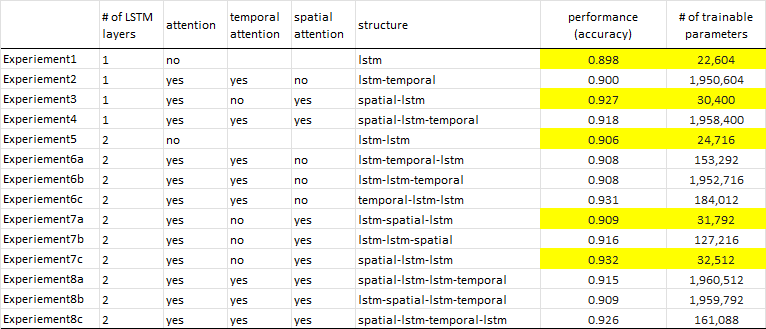

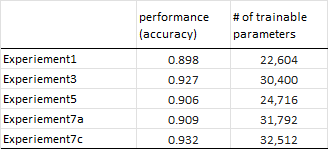

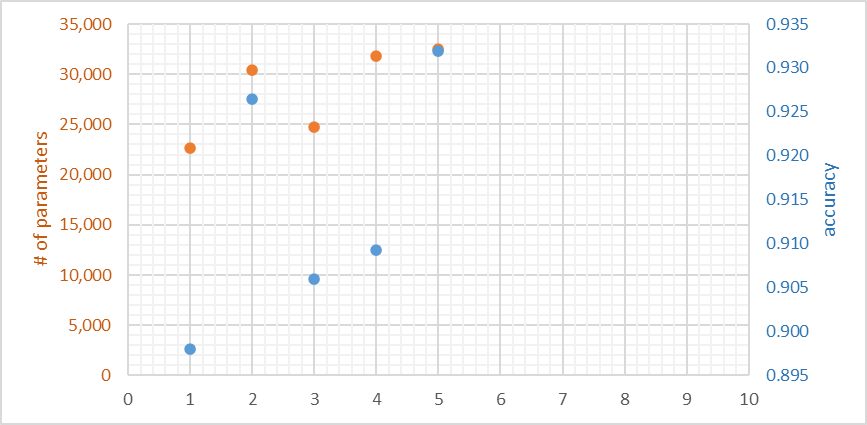

